Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import correlation


Reading input data

In [2]:
df = pd.read_csv('egypt_tourist_locations.csv')
df.head()

,location_id,location_name,category,location,latitude,longitude,rating,user_id
0,1001,Pyramids of Giza,Historical Landmark,Giza,29.9792,31.1342,4.5,1
1,1002,Karnak Temple,Landmark,Luxor,25.7188,32.6573,4.6,1
2,1003,Valley of the Kings,Historical Landmark,Luxor,25.7401,32.6012,4.7,1
3,1004,Abu Simbel,Historical Landmark,Aswan,22.3375,31.6258,4.8,1
4,1005,Muizz Street,Market,Cairo,30.0404,31.2494,4.4,1


<Axes: xlabel='user_id', ylabel='category'>

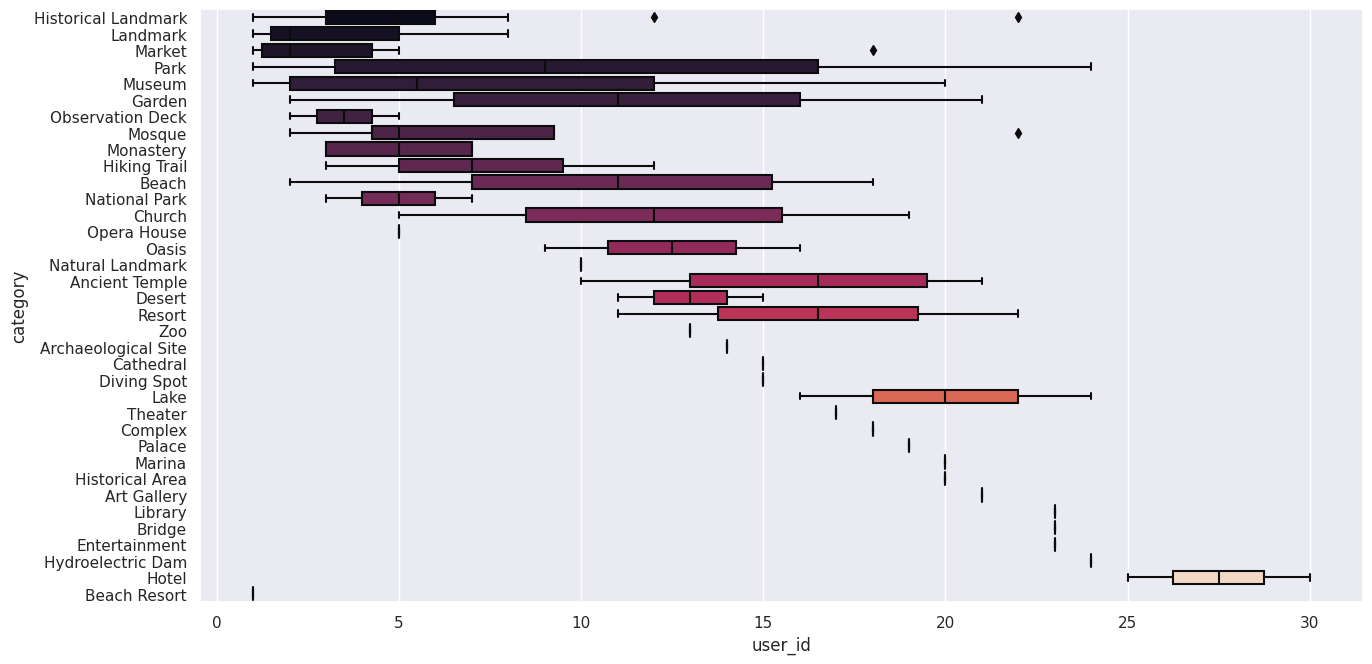

In [8]:
# Step 3: Analyze data
# We can visualize the data using a scatterplot to see if there is a relationship between the input features and output classes

import seaborn as sns

sns.set(rc={'figure.figsize':(15, 7.7)})
sns.boxplot(x='user_id', y='category', data=df, palette='rocket')

Preparing the user-item rating matrix

In [9]:
userItemRatingMatrix = pd.pivot_table(
    df,
    values='rating',
    index=['user_id'],
    columns=['location_id']
)

Returns the top recommended locations for a given user based on their ratings

In [10]:
def favoritePlace(activeUser, recommendedNumber):
    topPlace = pd.DataFrame.sort_values(df[df.user_id == activeUser], [
                                        'rating'], ascending=[0])[:recommendedNumber]
    return list(topPlace.location_name)

Top recommended categories for a given user based on their ratings

In [11]:
def favoriteCategory(activeUser, recommendedNumber):
    topCategoty = pd.DataFrame.sort_values(df[df.user_id == activeUser], [
                                        'rating'], ascending=[0])[:recommendedNumber]
    return {cat for cat in topCategoty.category}

Calculates the similarity between two users using the correlation metric

In [12]:
def similarity(user1, user2):
    try:
        # Compute the mean of the ratings for each user
        user1_mean = np.nanmean(user1)
        user2_mean = np.nanmean(user2)

        # Normalize the ratings by subtracting the mean
        user1_norm = np.array(user1) - user1_mean
        user2_norm = np.array(user2) - user2_mean

        # Find the indices of the common rated items
        commonItemIds = [i for i in range(
            len(user1_norm)) if user1_norm[i] > 0 and user2_norm[i] > 0]

        if len(commonItemIds) == 0:
            return 0
        else:
            # Compute the correlation between the normalized ratings
            user1_common = np.array([user1_norm[i] for i in commonItemIds])
            user2_common = np.array([user2_norm[i] for i in commonItemIds])
            return correlation(user1_common, user2_common)
    except ZeroDivisionError:
        print("You can't divide by zero!")

Returns the K nearest neighbours of a given user based on their rating similarity

In [13]:
def nearestNeighbour(activeUser, K):
    """
    nearest Neighbour Ratings
    """
    try:
        # Compute the similarity between the active user and all other users
        similarityMatrix = pd.DataFrame(
            index=userItemRatingMatrix.index, columns=['Similarity'])
        for i in userItemRatingMatrix.index:
            similarityMatrix.loc[i] = similarity(
                userItemRatingMatrix.loc[activeUser], userItemRatingMatrix.loc[i])

        # Sort the users by similarity and take the top K
        similarityMatrix = similarityMatrix.sort_values(
            by='Similarity', ascending=False)
        nearestNeighbours = similarityMatrix[:K]

        # Retrieve the ratings of the nearest neighbors for all items
        neighbourItemRatings = userItemRatingMatrix.loc[nearestNeighbours.index]

        # Predict the ratings for the active user for all items
        predictItemRating = pd.DataFrame(
            index=userItemRatingMatrix.columns, columns=['Rating'])
        for i in userItemRatingMatrix.columns:
            predictedRating = np.nanmean(userItemRatingMatrix.loc[activeUser])
            for j in neighbourItemRatings.index:
                if userItemRatingMatrix.loc[j, i] > 0:
                    predictedRating += (userItemRatingMatrix.loc[j, i]-np.nanmean(
                        userItemRatingMatrix.loc[j]))*nearestNeighbours.loc[j, 'Similarity']
            predictItemRating.loc[i, 'Rating'] = predictedRating

    except ZeroDivisionError:
        print("You can't divide by zero!")
    return predictItemRating


Rreturns the top N recommended locations for a given user based on their ratings and similarity to other users

In [14]:
def topNRecommendations(activeUser, N):
    """
      first:
        calls the nearestNeighbour function to get the predicted ratings for all the locations that the active user has not already rated.
      Then:
        It then removes the locations that the active user has already rated and sorts the predicted ratings in descending order.
      Finally,
      it returns a list of the top N recommended locations for the active user based on their predicted ratings.
    """
    try:
        predictItemRating = nearestNeighbour(activeUser, 10)
        placeAlreadyWatched = list(
            userItemRatingMatrix.loc[activeUser].loc[userItemRatingMatrix.loc[activeUser] > 0].index)
        predictItemRating = predictItemRating.drop(placeAlreadyWatched)
        topRecommendations = pd.DataFrame.sort_values(
            predictItemRating,
            ['Rating'], ascending=[0])[:N]
        topRecommendationTitles = (
            df.loc[df.location_id.isin(topRecommendations.index)])
    except ZeroDivisionError:
        print("You can't divide by zero!")
    return list(topRecommendationTitles.location_name)

implements a simple recommendation system using collaborative filtering technique, which recommends tourist locations to users based on their ratings and similarity to other users.

In [17]:
activeUser = int(input("Enter userid: "))
print(f"The user's favorite places are: {favoritePlace(activeUser, 5)}")
print(f"The user's favorite category are: {favoriteCategory(activeUser, 5)}")
print(f"The recommended places for you are: {topNRecommendations(activeUser, 5)}")

Enter userid: 22
The user's favorite places are: ['Monte Carlo Sharm Resort & Spa', 'El Rifai Mosque', 'Ramses Station']
The user's favorite category are: {'Mosque', 'Historical Landmark', 'Resort'}
The recommended places for you are: ['Pyramids of Giza', 'Karnak Temple', 'Qarun Lake', 'Mersa Alam Beach', 'Ancient Roman Theater']
